## Importiere `pandas`, `matplotlib`

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *
from matplotlib.patches import Patch

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [13]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [14]:
env = 'final'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

In [15]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [16]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [17]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Füge ein neues Feature hinzu: Themengebiet

In [18]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topics[topic]['name']

#### Ändere die Spalte `ressort` zu einem Anfangsgroßbuchstaben

In [19]:
df.ressort = df.ressort.str.title()

#### Zähle die Artikel pro Themengebiet

In [20]:
df_topic = df.topic.value_counts().reset_index(name="amount")
df_topic['color'] = "#f2cc8f" # ORANGE
df_topic['edgecolor'] = "#e07a5f" # ORANGE
df_topic['type'] = "topic"

#### Zähle die Artikel pro Ressort

In [21]:
df_ressort = df.ressort.value_counts().reset_index(name="amount")
df_ressort['color'] = "#8ecae6" # BLUE
df_ressort['edgecolor'] = "#219ebc" # BLUE
df_ressort['type'] = "ressort"

#### Füge die beiden enstandenen Daten in einen `DataFrame`

In [22]:
df = pd.concat([df_ressort, df_topic])

#### Sortiere die Anzahl der Artikel pro Themengebiet/Ressort (absteigend)

In [23]:
df = df.sort_values("amount", ascending=False)

#### Benenne das Feature `index` zu `group`

In [24]:
df['group'] = df['index']

## Erstelle das Diagramm

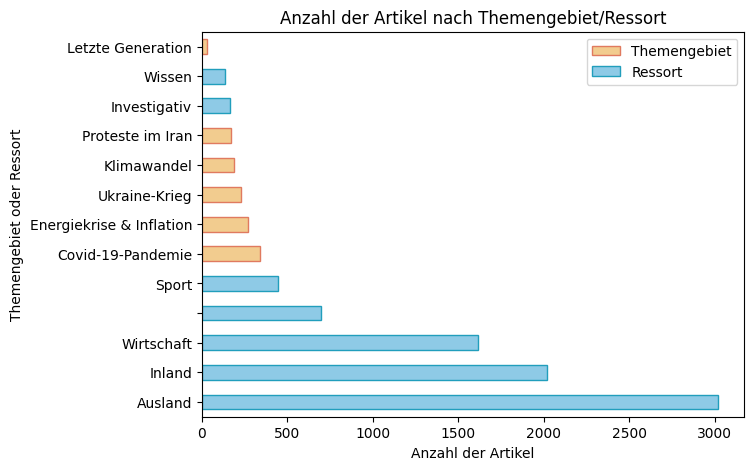

In [25]:
ax = df.plot(kind="barh", x="index", y="amount", figsize=(7,5), xlabel="Anzahl der Artikel", ylabel="Themengebiet oder Ressort", legend=False, rot=0, color=df.color, edgecolor=df.edgecolor, title="Anzahl der Artikel nach Themengebiet/Ressort")

legend_elements = [Patch(facecolor='#f2cc8f', edgecolor='#e07a5f', label='Themengebiet'), Patch(facecolor='#8ecae6', edgecolor='#219ebc', label='Ressort')]
ax.legend(handles=legend_elements);

ax.get_figure().savefig('figures/bar-topic-ressort.png', bbox_inches="tight", dpi=float(dpi))

#### Tausche helle Farben durch dunkle Farben aus

In [26]:
def switch_colors(hex):
    if hex == '#f2cc8f':
        return '#DC921A'
    elif hex == '#e07a5f':
        return '#7A510E'
    elif hex == '#8ecae6':
        return '#257EA7'
    elif hex == '#219ebc':
        return '#156579'

df.color = df.color.apply(switch_colors)
df.edgecolor = df.edgecolor.apply(switch_colors)

#### Mache Abstufungen in den Farbintensitäten, indem Transparenzwerte angehangen werden

In [27]:
# transparent value from 100% - 10% * n; >34%
transparencies = ["FF", "E6", "CC",  "B3",  "99",  "80",  "66", "4D"]
used = {"topic": -1, "ressort": -1}

def highlight_color(row):
    used[row.type] += 1
    row.color += transparencies[used[row.type]]
    return row
    
df = df.apply(highlight_color, axis=1)

#### Füge ein neues Feature hinz: `padding` als `explode` Wert für Tortendiagramm 

In [28]:
df.loc[(df.amount < 500), 'padding'] = 0.3

df['padding'] = df['padding'].fillna(0)

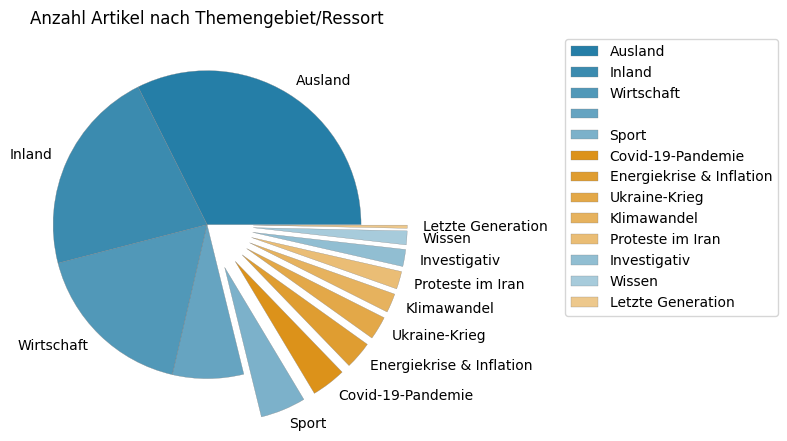

In [29]:
ax = df.plot(kind="pie", x="group", y="amount", figsize=(7,5), labels=df.group, explode=df.padding, fontsize=10, colors=df.color, legend=True, title="Anzahl Artikel nach Themengebiet/Ressort", wedgeprops={"edgecolor": "grey", 'linewidth': 0.2, 'linestyle': 'solid', 'antialiased': True})

ax.axes.get_yaxis().get_label().set_visible(False)

ax.legend(labels=df.group, bbox_to_anchor=(2.0, 1.0))

ax.get_figure().savefig('figures/pie-topic-ressort.png', bbox_inches="tight", dpi=float(dpi))